# UVIT view of Centaurus A; a detailed study on positive AGN feedback
## Jupyter notebooks used in the study: Notebook 3

We are making the scripts used for the study publicly available. This notebook is associated with the section 3.3 of the article. 

The cell below enable jupyter widget for matplotlib. It can produce interactive matplotlib inline plots. Please comment it if you do not have it installed. 

In [1]:
%matplotlib widget

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from astropy import units as u
from astropy.io import fits
from astropy.table import Table
from astropy.stats import sigma_clip, mad_std, median_absolute_deviation
from astropy.coordinates import SkyOffsetFrame, ICRS, SkyCoord
from scipy.interpolate import interp1d

In [3]:
def flux_to_mag(flux_at_mean_lambda, mean_lambda):
    mag = -2.5 * np.log10(flux_at_mean_lambda * mean_lambda ** 2 / (3e8 * 1e10)) - 48.6
    return mag

# Calzetti (2000) attenuation law
def estimate_calzetti(wavelength, color_excess): # Wavelength is in angstroms
    wavelength = wavelength / 1e4 
    
    if np.max(wavelength) >= 0.63:
        print('Check input values!')
        return
        
    k_lambda = 2.659 * (-2.156 + \
                        1.509 / wavelength - \
                        0.198 / (wavelength ** 2) + \
                        0.011 / (wavelength ** 3)) + \
                        4.05 
    
    flux_att = 10 ** (0.4 * k_lambda * color_excess) 
    return flux_att

def band_luminosity(wavelength, effective_area, luminosity):
    weighted_luminosity = luminosity * effective_area
    numerator = np.trapz(weighted_luminosity, x = wavelength)
    denominator = np.trapz(effective_area, x = wavelength)
    luminosity_at_mean_wavelength = numerator / denominator
    return luminosity_at_mean_wavelength

def filter_weighted_att(wavelength, effective_area, flux_att_factors):
    weighted_flux_att_factors = flux_att_factors * effective_area
    numerator = np.trapz(weighted_flux_att_factors, x = wavelength)
    denominator = np.trapz(effective_area, x = wavelength)
    filter_weighted_attenuation = numerator / denominator
    return filter_weighted_attenuation

In [4]:
where_is_data = 'data/'

hdu = fits.open(where_is_data + 'Kroupa_0.1M_v00-h.fits.gz')
# hdu = fits.open(where_is_data + 'Kroupa_0.1M_v40-h.fits.gz')

In [5]:
fuv_filters = pd.read_csv(where_is_data + '2020calpaper_uvit_FUV_filter_EA.txt', delim_whitespace=True)
nuv_filters = pd.read_csv(where_is_data + '2020calpaper_uvit_NUV_filter_EA.txt', delim_whitespace=True)

In [6]:
# # from 2020 paper
F148W_info  = [1481, 500]
F148Wa_info = [1485, 500]
F154W_info  = [1541, 380]
F172M_info  = [1717, 125]
F169M_info  = [1608, 290]

N242W_info = [2418, 785]
N242Wa_info = [2418, 785]
N245M_info = [2447, 280]
N263M_info = [2632, 275]
N219M_info = [2196, 270]
N279N_info = [2792, 90 ] 

F148W_correction = 0.779
F154W_correction = 0.787
F169M_correction = 0.876
F172M_correction = 0.892

N219M_correction = 0.540
N242W_correction = 0.814
N245M_correction = 0.805
N263M_correction = 0.824
N279N_correction = 0.848

F148W = fuv_filters[fuv_filters['Filtername'] == 'F148W']
F154W = fuv_filters[fuv_filters['Filtername'] == 'F154W']
F172M = fuv_filters[fuv_filters['Filtername'] == 'F172M']
F169M = fuv_filters[fuv_filters['Filtername'] == 'F169M']

N219M = nuv_filters[nuv_filters['Filtername'] == 'N219M']
N242W = nuv_filters[nuv_filters['Filtername'] == 'N242W']
N245M = nuv_filters[nuv_filters['Filtername'] == 'N245M']
N263M = nuv_filters[nuv_filters['Filtername'] == 'N263M']
N279N = nuv_filters[nuv_filters['Filtername'] == 'N279N']

linear_interpolated_F148W = interp1d(F148W['#Wavelength(A)'], F148W['EA(cm2)'] * F148W_correction, bounds_error = False, fill_value = 0)
linear_interpolated_F154W = interp1d(F154W['#Wavelength(A)'], F154W['EA(cm2)'] * F154W_correction, bounds_error = False, fill_value = 0)
linear_interpolated_F172M = interp1d(F172M['#Wavelength(A)'], F172M['EA(cm2)'] * F172M_correction, bounds_error = False, fill_value = 0)
linear_interpolated_F169M = interp1d(F169M['#Wavelength(A)'], F169M['EA(cm2)'] * F169M_correction, bounds_error = False, fill_value = 0)

linear_interpolated_N219M = interp1d(N219M['#Wavelength(A)'], N219M['EA(cm2)'] * N219M_correction, bounds_error = False, fill_value = 0)
linear_interpolated_N242W = interp1d(N242W['#Wavelength(A)'], N242W['EA(cm2)'] * N242W_correction, bounds_error = False, fill_value = 0)
linear_interpolated_N245M = interp1d(N245M['#Wavelength(A)'], N245M['EA(cm2)'] * N245M_correction, bounds_error = False, fill_value = 0)
linear_interpolated_N263M = interp1d(N263M['#Wavelength(A)'], N263M['EA(cm2)'] * N263M_correction, bounds_error = False, fill_value = 0)
linear_interpolated_N279N = interp1d(N279N['#Wavelength(A)'], N279N['EA(cm2)'] * N279N_correction, bounds_error = False, fill_value = 0)

F148W_EA_corrected = F148W['EA(cm2)'] * F148W_correction
N219M_EA_corrected = N219M['EA(cm2)'] * N219M_correction
N245M_EA_corrected = N245M['EA(cm2)'] * N245M_correction
N279N_EA_corrected = N279N['EA(cm2)'] * N279N_correction

F148W_flux_att_factors = estimate_calzetti(F148W['#Wavelength(A)'].to_numpy(), 0.1)
F148W_flux_att = filter_weighted_att(F148W['#Wavelength(A)'], F148W_EA_corrected, F148W_flux_att_factors)

In [7]:
distance = 3.8 #mpc
luminosity_factor = (4 * np.pi * ((distance * 1E6 * 3.0857 * 1E18) ** 2)) 

In [8]:
time = hdu[1].data['TIME(YR)']
epochs = len(np.unique(time))
no_of_lines_in_spectrum = int(len(time) / len(np.unique(time)))
time = time.reshape(epochs, no_of_lines_in_spectrum)
wavelength = hdu[1].data['WAVELENGTH']
wavelength = wavelength.reshape(epochs, no_of_lines_in_spectrum)
luminosity = np.power(10, hdu[1].data['LOG(LUMINOSITY)']) # ERG/SEC/A
luminosity = luminosity.reshape(epochs, no_of_lines_in_spectrum)

In [9]:
F148W_effective_area = linear_interpolated_F148W(wavelength[0])
F154W_effective_area = linear_interpolated_F154W(wavelength[0])
F172M_effective_area = linear_interpolated_F172M(wavelength[0])
F169M_effective_area = linear_interpolated_F169M(wavelength[0])

N219M_effective_area = linear_interpolated_N219M(wavelength[0])
N242W_effective_area = linear_interpolated_N242W(wavelength[0])
N245M_effective_area = linear_interpolated_N245M(wavelength[0])
N263M_effective_area = linear_interpolated_N263M(wavelength[0])
N279N_effective_area = linear_interpolated_N279N(wavelength[0])

In [10]:
F148W_simulated_luminosity = band_luminosity(wavelength, F148W_effective_area, luminosity)
F154W_simulated_luminosity = band_luminosity(wavelength, F154W_effective_area, luminosity)
F172M_simulated_luminosity = band_luminosity(wavelength, F172M_effective_area, luminosity)
F169M_simulated_luminosity = band_luminosity(wavelength, F169M_effective_area, luminosity)

N242W_simulated_luminosity = band_luminosity(wavelength, N242W_effective_area, luminosity)
N245M_simulated_luminosity = band_luminosity(wavelength, N245M_effective_area, luminosity)
N263M_simulated_luminosity = band_luminosity(wavelength, N263M_effective_area, luminosity)
N219M_simulated_luminosity = band_luminosity(wavelength, N219M_effective_area, luminosity)
N279N_simulated_luminosity = band_luminosity(wavelength, N279N_effective_area, luminosity)

In [11]:
F148W_simulated_mag = flux_to_mag(F148W_simulated_luminosity / luminosity_factor, F148W_info[0])
F154W_simulated_mag = flux_to_mag(F154W_simulated_luminosity / luminosity_factor, F154W_info[0])
F172M_simulated_mag = flux_to_mag(F172M_simulated_luminosity / luminosity_factor, F172M_info[0])
F169M_simulated_mag = flux_to_mag(F169M_simulated_luminosity / luminosity_factor, F169M_info[0])

N242W_simulated_mag = flux_to_mag(N242W_simulated_luminosity / luminosity_factor, N242W_info[0])
N245M_simulated_mag = flux_to_mag(N245M_simulated_luminosity / luminosity_factor, N245M_info[0])
N263M_simulated_mag = flux_to_mag(N263M_simulated_luminosity / luminosity_factor, N263M_info[0])
N219M_simulated_mag = flux_to_mag(N219M_simulated_luminosity / luminosity_factor, N219M_info[0])
N279N_simulated_mag = flux_to_mag(N279N_simulated_luminosity / luminosity_factor, N279N_info[0])

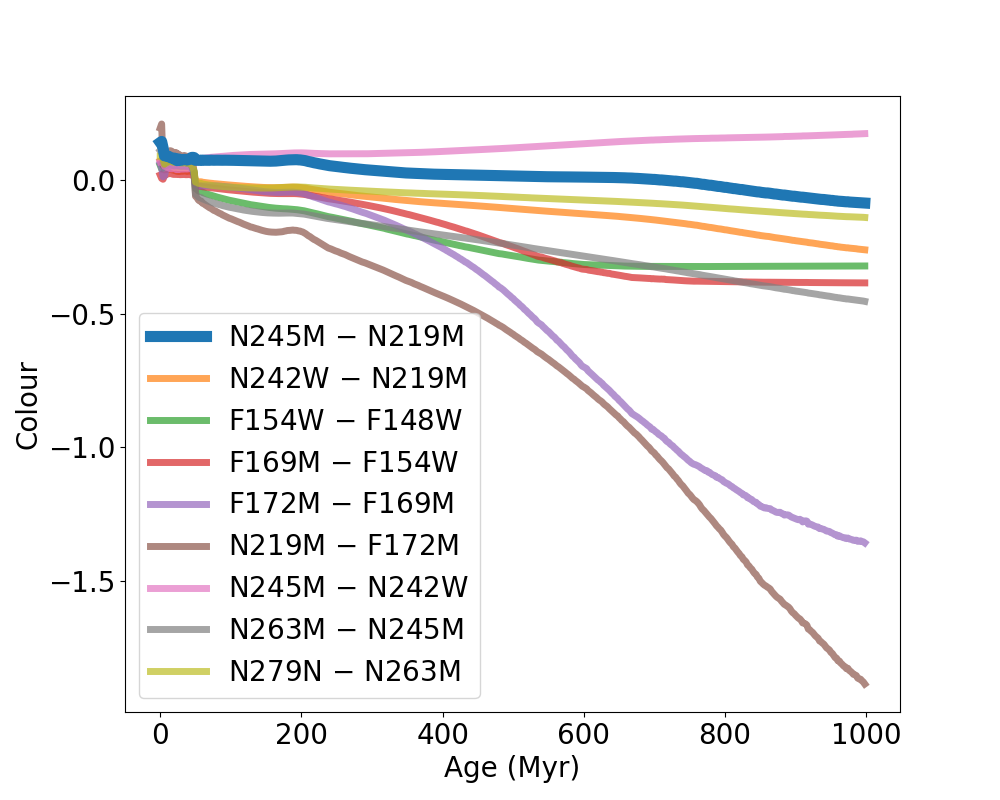

In [12]:
plt.rcParams.update({'font.size': 20})
fig, ax = plt.subplots(figsize=(10, 8))


ax.plot(np.unique(time) / 1e6,  N245M_simulated_mag - N219M_simulated_mag,
        label = 'N245M $-$ N219M',
        linewidth = 8, zorder=10)

alpha = 0.7
linewidth = 5
ax.plot(np.unique(time) / 1e6, N242W_simulated_mag - N219M_simulated_mag,
        label = 'N242W $-$ N219M',
        linewidth = linewidth, alpha = alpha)

ax.plot(np.unique(time) / 1e6, F154W_simulated_mag - F148W_simulated_mag,
        label = 'F154W $-$ F148W',
        linewidth = linewidth, alpha = alpha)

ax.plot(np.unique(time) / 1e6, F169M_simulated_mag - F154W_simulated_mag,
        label = 'F169M $-$ F154W',
        linewidth = linewidth, alpha = alpha)

ax.plot(np.unique(time) / 1e6, F172M_simulated_mag - F169M_simulated_mag,
        label = 'F172M $-$ F169M',
        linewidth = linewidth, alpha = alpha)

ax.plot(np.unique(time) / 1e6, N219M_simulated_mag - F172M_simulated_mag,
        label = 'N219M $-$ F172M',
        linewidth = linewidth, alpha = alpha)

ax.plot(np.unique(time) / 1e6, N245M_simulated_mag - N242W_simulated_mag,
        label = 'N245M $-$ N242W',
        linewidth = linewidth, alpha = alpha)

ax.plot(np.unique(time) / 1e6, N263M_simulated_mag - N245M_simulated_mag,
        label = 'N263M $-$ N245M',
        linewidth = linewidth, alpha = alpha)

ax.plot(np.unique(time) / 1e6, N279N_simulated_mag - N263M_simulated_mag,
        label = 'N279N $-$ N263M',
        linewidth = linewidth, alpha = alpha)

ax.legend()

ax.set_xlabel('Age (Myr)')
ax.set_ylabel('Colour')

fig.savefig('UVIT_filter_colors.png', dpi = 150, bbox_inches = 'tight')

In [13]:
age_from_N219M_F148W_color = interp1d(N219M_simulated_mag - F148W_simulated_mag, 
                                   np.unique(time) / 1e6, bounds_error = False)

age_from_N245M_F148W_color = interp1d(N245M_simulated_mag - F148W_simulated_mag, 
                                   np.unique(time) / 1e6, bounds_error = False)

age_from_N279N_F148W_color = interp1d(N279N_simulated_mag - F148W_simulated_mag, 
                                   np.unique(time) / 1e6, bounds_error = False)

In [14]:
F148W_mag_from_age = interp1d(np.unique(time) / 1e6, F148W_simulated_mag)
N219M_mag_from_age = interp1d(np.unique(time) / 1e6, N219M_simulated_mag)
N245M_mag_from_age = interp1d(np.unique(time) / 1e6, N245M_simulated_mag)                              

In [15]:
N245M_N219M_simulated_color = N245M_simulated_mag - N219M_simulated_mag 
median_N245M_N219M_simulated_color = np.median(N245M_N219M_simulated_color[12:150])
# median_N245M_N219M_simulated_color = 0.074 #for v00 model
# median_N245M_N219M_simulated_color = 0.075 #for V40 model

In [16]:
N245M_N219M_color_from_age = interp1d(np.unique(time) / 1e6,
                                      N245M_simulated_mag - N219M_simulated_mag)

In [17]:
jet_PA = 37.39994 #degrees, from total intensity 6.3 cm radio data. 

# From NED.
CenA_ra = 201.3650634
CenA_dec = -43.0191126
cenA_centre = SkyCoord(CenA_ra * u.deg, CenA_dec * u.deg, frame = 'icrs') 

arcsec_to_kpc = 3.8E3 * np.pi / (180 * 60 * 60)

# Outer region
outer_filament_ra = 201.5884734
outer_filament_dec = -42.8144597
outer_filament_radius = 4.5 * u.arcminute
outer_filament_centre = SkyCoord(outer_filament_ra * u.deg, 
                                 outer_filament_dec * u.deg, 
                                 frame = 'icrs')

# Inner region
inner_filament_ra = 201.4875682
inner_filament_dec = -42.9561239
inner_filament_radius = 4.5 * u.arcminute
inner_filament_centre = SkyCoord(inner_filament_ra * u.deg, 
                                 inner_filament_dec * u.deg, 
                                 frame = 'icrs')

tbl = Table.read('SF_sources.fits')

tbl_coo = SkyCoord(tbl['RA_J2000'] * u.deg, tbl['DEC_J2000'] * u.deg, frame = 'icrs')
cenA_rotated_frame = cenA_centre.skyoffset_frame(rotation = jet_PA * u.deg)
rotated_coo = tbl_coo.transform_to(cenA_rotated_frame)
tbl['rotated_coo'] = rotated_coo

In [18]:
outer_mask = outer_filament_centre.separation(tbl_coo) < outer_filament_radius
sorted_outer_tbl = tbl[outer_mask]

ratio_cost = 1
colour_excess = 0.005

while abs(ratio_cost) > 0.00001:
    N219M_flux_att_factors = estimate_calzetti(N219M['#Wavelength(A)'].to_numpy(), colour_excess)
    N245M_flux_att_factors = estimate_calzetti(N245M['#Wavelength(A)'].to_numpy(), colour_excess)
    N219M_insitu_att = filter_weighted_att(N219M['#Wavelength(A)'], N219M_EA_corrected, N219M_flux_att_factors)  
    N245M_insitu_att = filter_weighted_att(N245M['#Wavelength(A)'], N245M_EA_corrected, N245M_flux_att_factors)  

    N219M_observed_flux = sorted_outer_tbl['N219M_ext_corrected_flux'] * N219M_insitu_att 
    N245M_observed_flux = sorted_outer_tbl['N245M_ext_corrected_flux'] * N245M_insitu_att 

    outer_N245M_N219M_observed_color = flux_to_mag(N245M_observed_flux, N245M_info[0]) - \
                                       flux_to_mag(N219M_observed_flux, N219M_info[0])
    
    mean_outer_N219M_by_N245M = np.median(outer_N245M_N219M_observed_color)    
        
    ratio_cost = median_N245M_N219M_simulated_color - mean_outer_N219M_by_N245M
    colour_excess = colour_excess + ratio_cost

print("colour_excess = {:.4f}".format(colour_excess))

# colour_excess = 0

F148W_flux_att_factors = estimate_calzetti(F148W['#Wavelength(A)'].to_numpy(), colour_excess)
N219M_flux_att_factors = estimate_calzetti(N219M['#Wavelength(A)'].to_numpy(), colour_excess)
N245M_flux_att_factors = estimate_calzetti(N245M['#Wavelength(A)'].to_numpy(), colour_excess)
N279N_flux_att_factors = estimate_calzetti(N279N['#Wavelength(A)'].to_numpy(), colour_excess)
F148W_insitu_att = filter_weighted_att(F148W['#Wavelength(A)'], F148W_EA_corrected, F148W_flux_att_factors)  
N219M_insitu_att = filter_weighted_att(N219M['#Wavelength(A)'], N219M_EA_corrected, N219M_flux_att_factors)  
N245M_insitu_att = filter_weighted_att(N245M['#Wavelength(A)'], N245M_EA_corrected, N245M_flux_att_factors)  
N279N_insitu_att = filter_weighted_att(N279N['#Wavelength(A)'], N279N_EA_corrected, N279N_flux_att_factors)  

F148W_observed_flux = sorted_outer_tbl['F148W_ext_corrected_flux'] * F148W_insitu_att 
N219M_observed_flux = sorted_outer_tbl['N219M_ext_corrected_flux'] * N219M_insitu_att 
N245M_observed_flux = sorted_outer_tbl['N245M_ext_corrected_flux'] * N245M_insitu_att 
N279N_observed_flux = sorted_outer_tbl['N279N_ext_corrected_flux'] * N279N_insitu_att 

outer_N219M_F148W_observed_color = flux_to_mag(N219M_observed_flux, N219M_info[0]) - \
                                   flux_to_mag(F148W_observed_flux, F148W_info[0])

outer_N245M_F148W_observed_color = flux_to_mag(N245M_observed_flux, N245M_info[0]) - \
                                   flux_to_mag(F148W_observed_flux, F148W_info[0])

outer_N279N_F148W_observed_color = flux_to_mag(N279N_observed_flux, N279N_info[0]) - \
                                   flux_to_mag(F148W_observed_flux, F148W_info[0])

outer_N245M_N219M_observed_color = flux_to_mag(N245M_observed_flux, N245M_info[0]) - \
                                   flux_to_mag(N219M_observed_flux, N219M_info[0])
    
sorted_outer_tbl['N219M_F148W_color'] = outer_N219M_F148W_observed_color
sorted_outer_tbl['N245M_F148W_color'] = outer_N245M_F148W_observed_color
sorted_outer_tbl['N245M_N219M_color'] = outer_N245M_N219M_observed_color

outer_age_N219M = age_from_N219M_F148W_color(np.median(outer_N219M_F148W_observed_color))
outer_age_N245M = age_from_N245M_F148W_color(np.median(outer_N245M_F148W_observed_color))
outer_age_N279N = age_from_N279N_F148W_color(np.median(outer_N279N_F148W_observed_color))

colour_excess = 0.0652


In [19]:
inner_mask = inner_filament_centre.separation(tbl_coo) < inner_filament_radius
sorted_inner_tbl = tbl[inner_mask]

ratio_cost = 1
colour_excess = 0.005

while abs(ratio_cost) > 0.00001:
    N219M_flux_att_factors = estimate_calzetti(N219M['#Wavelength(A)'].to_numpy(), colour_excess)
    N245M_flux_att_factors = estimate_calzetti(N245M['#Wavelength(A)'].to_numpy(), colour_excess)
    N219M_insitu_att = filter_weighted_att(N219M['#Wavelength(A)'], N219M_EA_corrected, N219M_flux_att_factors)  
    N245M_insitu_att = filter_weighted_att(N245M['#Wavelength(A)'], N245M_EA_corrected, N245M_flux_att_factors)  

    N219M_observed_flux = sorted_inner_tbl['N219M_ext_corrected_flux'] * N219M_insitu_att 
    N245M_observed_flux = sorted_inner_tbl['N245M_ext_corrected_flux'] * N245M_insitu_att 

    inner_N245M_N219M_observed_color = flux_to_mag(N245M_observed_flux, N245M_info[0]) - \
                                       flux_to_mag(N219M_observed_flux, N219M_info[0])
    
    mean_inner_N219M_by_N245M = np.median(inner_N245M_N219M_observed_color)    
        
    ratio_cost = median_N245M_N219M_simulated_color - mean_inner_N219M_by_N245M
    colour_excess = colour_excess + ratio_cost

print("colour_excess = {:.4f}".format(colour_excess))

# colour_excess = 0

F148W_flux_att_factors = estimate_calzetti(F148W['#Wavelength(A)'].to_numpy(), colour_excess)
N219M_flux_att_factors = estimate_calzetti(N219M['#Wavelength(A)'].to_numpy(), colour_excess)
N245M_flux_att_factors = estimate_calzetti(N245M['#Wavelength(A)'].to_numpy(), colour_excess)
N279N_flux_att_factors = estimate_calzetti(N279N['#Wavelength(A)'].to_numpy(), colour_excess)
F148W_insitu_att = filter_weighted_att(F148W['#Wavelength(A)'], F148W_EA_corrected, F148W_flux_att_factors)  
N219M_insitu_att = filter_weighted_att(N219M['#Wavelength(A)'], N219M_EA_corrected, N219M_flux_att_factors)  
N245M_insitu_att = filter_weighted_att(N245M['#Wavelength(A)'], N245M_EA_corrected, N245M_flux_att_factors)  
N279N_insitu_att = filter_weighted_att(N279N['#Wavelength(A)'], N279N_EA_corrected, N279N_flux_att_factors)  

F148W_observed_flux = sorted_inner_tbl['F148W_ext_corrected_flux'] * F148W_insitu_att 
N219M_observed_flux = sorted_inner_tbl['N219M_ext_corrected_flux'] * N219M_insitu_att 
N245M_observed_flux = sorted_inner_tbl['N245M_ext_corrected_flux'] * N245M_insitu_att 
N279N_observed_flux = sorted_inner_tbl['N279N_ext_corrected_flux'] * N279N_insitu_att 

inner_N219M_F148W_observed_color = flux_to_mag(N219M_observed_flux, N219M_info[0]) - \
                                   flux_to_mag(F148W_observed_flux, F148W_info[0])

inner_N245M_F148W_observed_color = flux_to_mag(N245M_observed_flux, N245M_info[0]) - \
                                   flux_to_mag(F148W_observed_flux, F148W_info[0])

inner_N279N_F148W_observed_color = flux_to_mag(N279N_observed_flux, N279N_info[0]) - \
                                   flux_to_mag(F148W_observed_flux, F148W_info[0])

inner_N245M_N219M_observed_color = flux_to_mag(N245M_observed_flux, N245M_info[0]) - \
                                   flux_to_mag(N219M_observed_flux, N219M_info[0])
    
sorted_inner_tbl['N219M_F148W_color'] = inner_N219M_F148W_observed_color
sorted_inner_tbl['N245M_F148W_color'] = inner_N245M_F148W_observed_color
sorted_inner_tbl['N245M_N219M_color'] = inner_N245M_N219M_observed_color

inner_age_N219M = age_from_N219M_F148W_color(np.median(inner_N219M_F148W_observed_color))
inner_age_N245M = age_from_N245M_F148W_color(np.median(inner_N245M_F148W_observed_color))
inner_age_N279N = age_from_N279N_F148W_color(np.median(inner_N279N_F148W_observed_color))

colour_excess = 0.2410


Median age (Outer region) = 64
Median age (Inner region) = 48


/tmp/ipykernel_15607/1482344344.py:16: RuntimeWarning: Mean of empty slice
  inner_average_ages = np.nanmean(inner_ages, axis = 0)


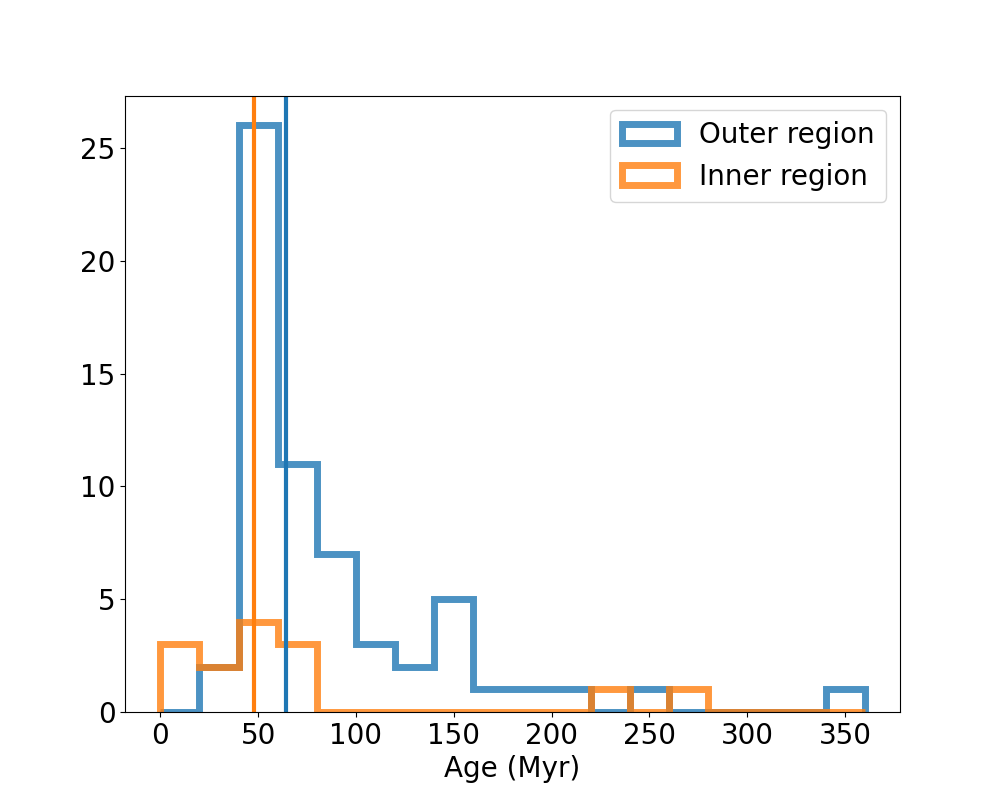

In [20]:
plt.rcParams.update({'font.size': 20})
fig, ax = plt.subplots(figsize=(10, 8))

alpha = 0.5
bins = np.arange(0, 380, 20)

outer_ages = np.array([age_from_N219M_F148W_color(sorted_outer_tbl['N219M_F148W_color']), 
                       age_from_N245M_F148W_color(sorted_outer_tbl['N245M_F148W_color'])])

outer_average_ages = np.nanmean(outer_ages, axis = 0)
sorted_outer_tbl['Age_Myr'] = outer_average_ages

inner_ages = np.array([age_from_N219M_F148W_color(sorted_inner_tbl['N219M_F148W_color']), 
                       age_from_N245M_F148W_color(sorted_inner_tbl['N245M_F148W_color'])])

inner_average_ages = np.nanmean(inner_ages, axis = 0)
sorted_inner_tbl['Age_Myr'] = inner_average_ages

ax.hist(outer_average_ages, bins= bins, alpha = 0.8, label = 'Outer region', histtype = 'step', linewidth=5)
ax.hist(inner_average_ages, bins= bins, alpha = 0.8, label = 'Inner region', histtype = 'step', linewidth=5)

ax.axvline(x = np.nanmedian(outer_average_ages), color = 'tab:blue', linewidth = 3)
ax.axvline(x = np.nanmedian(inner_average_ages), color = 'tab:orange', linewidth = 3)

ax.set_xlabel('Age (Myr)')
ax.legend(loc = 'upper right')

print("Median age (Outer region) = {}".format(int(np.round(np.nanmedian(outer_average_ages)))))
print("Median age (Inner region) = {}".format(int(np.round(np.nanmedian(inner_average_ages)))))

fig.savefig('age_distribution.png', dpi = 150, bbox_inches = 'tight')

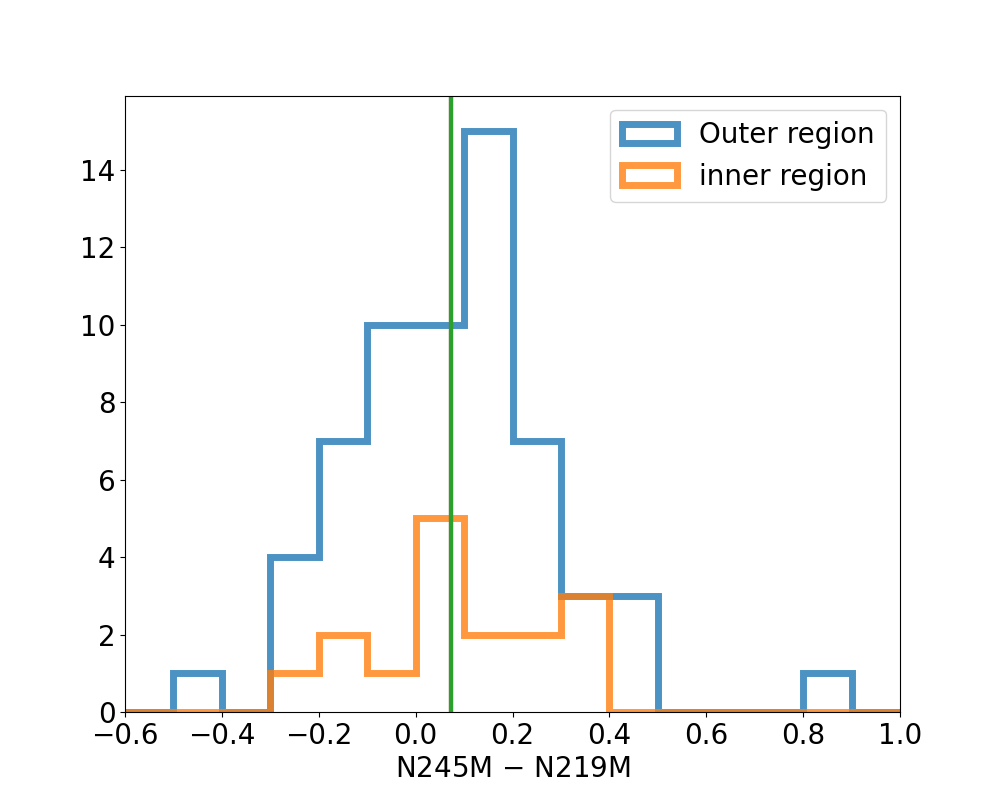

In [21]:
plt.rcParams.update({'font.size': 20})
fig, ax = plt.subplots(figsize=(10, 8))

alpha = 0.5
bins = np.arange(-2, 2, 0.1)
ax.hist(outer_N245M_N219M_observed_color, bins= bins, alpha = 0.8, label = 'Outer region', histtype = 'step', linewidth=5)
ax.hist(inner_N245M_N219M_observed_color, bins= bins, alpha = 0.8, label = 'inner region', histtype = 'step', linewidth=5)

linewidth = 3
ax.axvline(x = np.median(outer_N245M_N219M_observed_color), color = 'tab:blue', linewidth = linewidth)
ax.axvline(x = np.median(inner_N245M_N219M_observed_color), color = 'tab:orange', linewidth = linewidth)
ax.axvline(x = median_N245M_N219M_simulated_color, color = 'tab:green', linewidth = linewidth)
ax.set_xlabel('N245M $-$ N219M')

ax.set_ylim(0, 15.9)
ax.set_xlim(-0.6, 1)

ax.legend()

fig.savefig('with_attenuation_correction.png', dpi = 150, bbox_inches = 'tight')

# uncomment the `colour_excess = 0` line to create plots without attenuation correction.  
# fig.savefig('without_attenuation_correction.png', dpi = 150, bbox_inches = 'tight') 

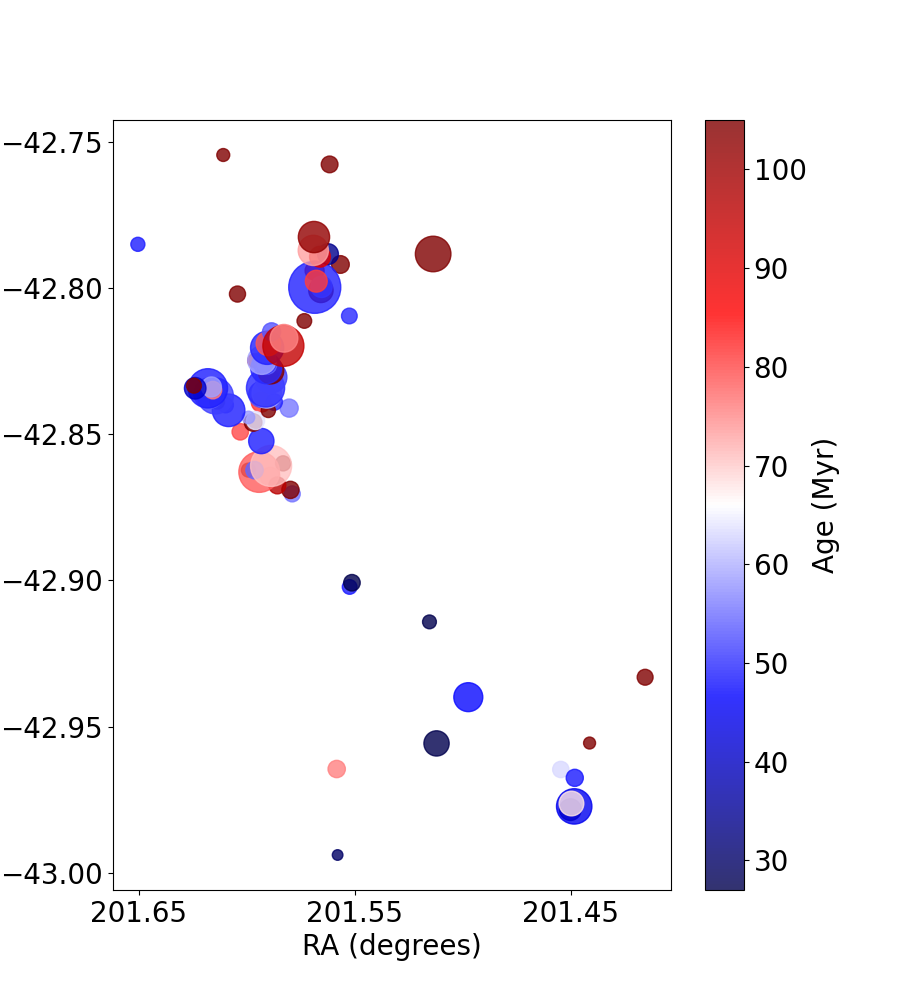

In [22]:
plt.rcParams.update({'font.size': 20})
fig, ax = plt.subplots(figsize=(9, 10))

ra_nsr = np.concatenate([sorted_outer_tbl['RA_J2000'], sorted_inner_tbl['RA_J2000']])
dec_nsr = np.concatenate([sorted_outer_tbl['DEC_J2000'], sorted_inner_tbl['DEC_J2000']])
age_nsr = np.concatenate([sorted_outer_tbl['Age_Myr'], sorted_inner_tbl['Age_Myr']])
size_nsr = np.concatenate([sorted_outer_tbl['F148W_area_kpc_square'], sorted_inner_tbl['F148W_area_kpc_square']])
size_nsr = (size_nsr * 30000) 

vmin = 27
vmax = 105
im = ax.scatter(ra_nsr, dec_nsr, c = age_nsr, vmin = vmin, vmax = vmax, alpha = 0.8, s= size_nsr, cmap='seismic')

ax.invert_xaxis()
cbar = fig.colorbar(im)

cbar.ax.set_ylabel('Age (Myr)')

custom_ticks = np.linspace(201.65, 201.45, 3)
ax.set_xticks(custom_ticks)
ax.set_xticklabels(custom_ticks)

ax.set_xlabel('RA (degrees)')
ax.set_ylabel('DEC (degrees)')

fig.savefig('age_map.png', dpi = 150, bbox_inches = 'tight')

In [23]:
# To find the age spread in Outer region.
np.round([np.nanmin(sorted_outer_tbl['Age_Myr']), np.nanmax(sorted_outer_tbl['Age_Myr'])])

array([ 25., 344.])

In [24]:
# To find the age spread in Inner region.
np.round([np.nanmin(sorted_inner_tbl['Age_Myr']), np.nanmax(sorted_inner_tbl['Age_Myr'])])

array([  4., 277.])

In [25]:
sorted_outer_tbl.remove_column('rotated_coo')
sorted_outer_tbl.write('sorted_outer_tbl.fits', format = 'fits', overwrite = True)

In [26]:
sorted_inner_tbl.remove_column('rotated_coo')
sorted_inner_tbl.write('sorted_inner_tbl.fits', format = 'fits', overwrite = True)